# Project Goal

You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a plant's species from a photo.

Can you differentiate a weed from a crop seedling?

The ability to do so effectively can mean better crop yields and better stewardship of the environment.
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

# Step 1: Import Libraries and Read the Data

In [ ]:
# Import necessary libraries

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#Fixing the seed for random number generators
np.random.seed(12)
import random
random.seed(12)
tf.random.set_seed(12)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the image dataset as X
X = np.load('/content/drive/My Drive/Colab Notebooks/Project-Computer-Vision/images.npy')

In [ ]:
# Print the shape of the X data
X.shape

(4750, 128, 128, 3)

In [ ]:
# View the Numpy representation of the first image
X[0]

array([[[ 35,  52,  78],
        [ 36,  49,  76],
        [ 31,  45,  69],
        ...,
        [ 78,  95, 114],
        [ 76,  93, 110],
        [ 80,  95, 109]],

       [[ 33,  46,  68],
        [ 37,  50,  73],
        [ 48,  65,  83],
        ...,
        [ 81,  96, 113],
        [ 74,  89, 105],
        [ 83,  95, 109]],

       [[ 34,  50,  68],
        [ 35,  52,  72],
        [ 70,  85, 101],
        ...,
        [ 83,  97, 112],
        [ 79,  94, 108],
        [ 79,  94, 107]],

       ...,

       [[ 35,  50,  69],
        [ 42,  57,  73],
        [ 42,  57,  72],
        ...,
        [ 60,  76,  92],
        [ 67,  81,  97],
        [ 64,  77,  95]],

       [[ 36,  52,  67],
        [ 48,  63,  78],
        [ 41,  57,  73],
        ...,
        [ 44,  66,  83],
        [ 58,  76,  91],
        [ 57,  74,  90]],

       [[ 44,  58,  70],
        [ 43,  57,  73],
        [ 40,  55,  72],
        ...,
        [ 41,  70,  92],
        [ 55,  78,  97],
        [ 61,  79,  96]]

#### Observations
* We have 4,750 images in the dataset
* Each image is 128 x 128 pixels
* Each image has 3 color channels (RGB)

In [ ]:
# Load the labels as y
y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project-Computer-Vision/Labels.csv')

In [ ]:
# Print the shape of the label data, y
y.shape

(4750, 1)

#### Observations
We have 4,750 labels, which matches the number of images

In [ ]:
# Check the first entry in the y data
y.iloc[0,0]

'Small-flowered Cranesbill'

In [ ]:
# Count the number of each label in the data
y.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

#### Observations
* We have 12 unique labels for the plants
* No null values for labels
* The labels are not equally distributed. Losse Silky-bent is the most common label and occurs almost 3 times as often as Maize and Common wheat

## Visualize images in the dataset

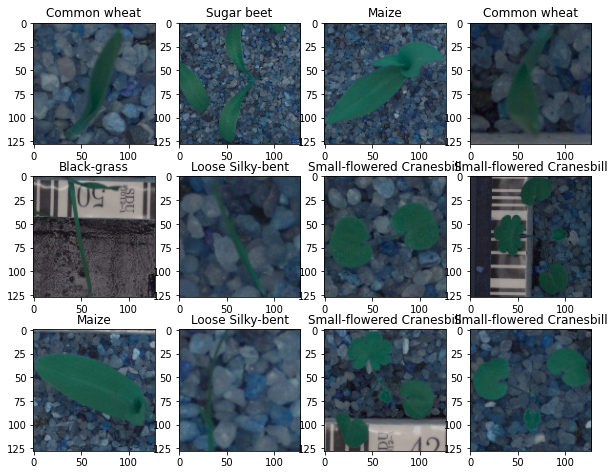

In [ ]:
# Create a plot to show random images from the numpy X data
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 8))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(X[random_index, :])
        ax.set_title(y.iloc[random_index, 0])
plt.show()

#### Observations
I can see that the images are of plant seedlings of various types. The images are color. The plants appear to be planted int rocks or something similar. 

# Step 2: Data Pre-Processing

## Normalize the Data

In [ ]:
# Convert data type to float32 so I can normalize it with decimal points
X = X.astype('float32') 

# Divide by 255 to normalize (the maximum RGB code minus the minimum RGB code)
X /= 255

In [ ]:
print("X shape:", X.shape)
print("Images in X:", X.shape[0])
print("Max value in X:", X.max())
print("Min value in X:", X.min())

X shape: (4750, 128, 128, 3)
Images in X: 4750
Max value in X: 1.0
Min value in X: 0.0


#### Observations
* Successfully normalized the data between 1 and 0. Still have 4,750 images of size 128 pixels by 128 pixels. 

## Blurring

In [ ]:
# Create a copy of the X data before applying blur
blur_X = np.copy(X)

In [ ]:
# Use Enumerate to apply Gaussian blur to the blur_X data
for idx, img in enumerate(blur_X):
  blur_X[idx] = cv2.GaussianBlur(img, (5, 5), 0)

In [ ]:
# Confirm the shape of the blur_X data is still as expected
blur_X.shape

(4750, 128, 128, 3)

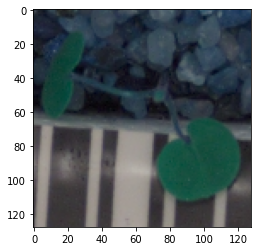

In [ ]:
# View original image from X data at index 10
plt.imshow(X[10])

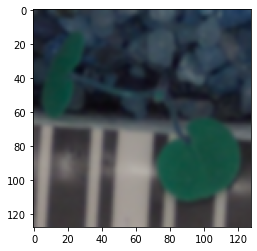

In [ ]:
# Compare to blurred image from blur_X data at index 10
plt.imshow(blur_X[10])

#### Observations
The blurring was effective. I can see that the same image is somewhat blurred in the blur_X array when compared to the original X array. 

## Vizualizing Data after Pre-Processing

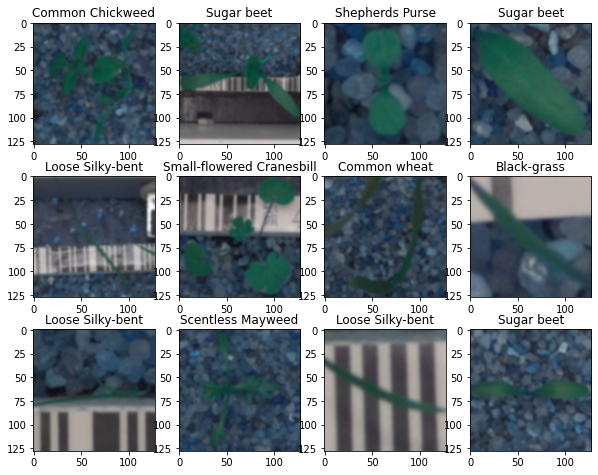

In [ ]:
# Create a plot to show random images that are now blurred
rows = 3
cols = 4
fig = plt.figure(figsize=(10, 8))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(blur_X[random_index, :])
        ax.set_title(y.iloc[random_index, 0])
plt.show()

#### Observations 
The quality of the images is still good, but I can tell that they are blurred now, which should help the model performance. 

# Step 3: Make the Data Compatible

## Reshape the Data

In [ ]:
# Need to verify that the data before continiuing.

blur_X.shape

(4750, 128, 128, 3)

#### Observations 
The Sequential model in tensorflow.keras expects data to be in the format (num of example, height in pixels, width in pixels, number of channels)

Keras also requires minimum size of 32 x 32

The blur_X data already in the correct format for Sequential model and are larger than 32 x 32 pixels, so I am not going to reshape the data. 

## Convert Classes to Numbers

In [ ]:
# Create a list of category names in alphabetical order (for use later)
plant_classes = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [ ]:
# Assign a numeric value to each Label 
label_dict = {'Black-grass':0, 'Charlock':1, 'Cleavers':2, 'Common Chickweed':3, 'Common wheat':4, 'Fat Hen':5, 'Loose Silky-bent':6, 'Maize':7, 'Scentless Mayweed':8, 'Shepherds Purse':9, 'Small-flowered Cranesbill':10, 'Sugar beet':11}

In [ ]:
# Replace the text labels with the numeric values from the dict
y.replace(label_dict, inplace=True)

In [ ]:
# Convert the labels to numpy array to feed into the supervised learning model.
y = y.values

#### Observations
Label data is now converted properly to a binary class matrix and prepped for the model

## Split the Data

In [ ]:
# Split data into test and train to build the model.
# Use 30% test size
X_train, X_test, y_train, y_test = train_test_split(blur_X, y, test_size=0.3, random_state=0)

In [ ]:
# Check the shape of the data to make sure the splitting worked
print("Shape of X_train data:", X_train.shape)
print("Shape of X_test data:", X_test.shape)
print("Shape of y_train data:", y_train.shape)
print("Shape of y_test data:", y_test.shape)

Shape of X_train data: (3325, 128, 128, 3)
Shape of X_test data: (1425, 128, 128, 3)
Shape of y_train data: (3325, 1)
Shape of y_test data: (1425, 1)


## One-Hot Encode the Class Vector

In [ ]:
# Convert class intgers to a binary class matrix
y_train_encoded = to_categorical(y_train, num_classes=12)
y_test_encoded = to_categorical(y_test, num_classes=12)

print("Shape of y_train_encoded data:", y_train_encoded.shape)
print("One value of y_train_encoded data:", y_train_encoded[0])

Shape of y_train_encoded data: (3325, 12)
One value of y_train_encoded data: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Observations
Splitting the data into 70% train and 30% test worked. The class data (y) is properly encoded. The data is now in the correct format and ready for the model.

# Step 4: Building Convolutional Neural Network

In [ ]:
# Define a Sequential model
model = tf.keras.Sequential()

In [ ]:
# Add 2 Convolutional Layers
# Use 32 filters with kernel size 3
# Use ReLu as the activation function
# Set the initial input shape to 128, 128, 3
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))

In [ ]:
# Flatten the 2D arrays to 1D array before feeding to the fully-connected dense layers
model.add(Flatten())

In [ ]:
# Add 2 dense layers

# Set the initial neurons to 128
# Use ReLu as the activation function
model.add(Dense(128, activation="relu"))

# Use 12 as the final neurons because there are 12 classes
# Use softmax to get probabilities for each class
model.add(Dense(12, activation="softmax"))

In [ ]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               62980224  
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 62,991,916
Trainable params: 62,991,916
Non-trainable params: 0
_________________________________________________________________


#### Observations
This first model has 2 convolutional layers, 1 flatten layer, and then 2 full-connected layers. Because the images are color and fairly large (128 x 128 pixels), there are almost 63 million trainable parameteres in this simple model! 

# Step 5: Compile and Fit the Model

In [ ]:
# Compile the model 
# Use categorical cross entropy for the loss function
# Use Adam as the loss function
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           save_freq='epoch')

In [ ]:
# Fit the model
# Split test into validation set of 50% size
history_1 = model.fit( x=X_train, y=y_train_encoded, batch_size=32, epochs=40, validation_split = 0.5, callbacks=[early_stopping, model_checkpoint])

Epoch 1/40
52/52 [==============================] - 34s 57ms/step - loss: 5.0068 - accuracy: 0.2491 - val_loss: 2.1517 - val_accuracy: 0.2796

Epoch 00001: val_loss improved from inf to 2.15174, saving model to checkpoint_01_loss2.1517.h5
Epoch 2/40
52/52 [==============================] - 2s 46ms/step - loss: 1.5771 - accuracy: 0.4657 - val_loss: 1.6123 - val_accuracy: 0.4438

Epoch 00002: val_loss improved from 2.15174 to 1.61231, saving model to checkpoint_02_loss1.6123.h5
Epoch 3/40
52/52 [==============================] - 2s 46ms/step - loss: 1.2075 - accuracy: 0.5945 - val_loss: 1.6619 - val_accuracy: 0.3836

Epoch 00003: val_loss did not improve from 1.61231
Epoch 4/40
52/52 [==============================] - 2s 46ms/step - loss: 1.0462 - accuracy: 0.6528 - val_loss: 1.5760 - val_accuracy: 0.4943

Epoch 00004: val_loss improved from 1.61231 to 1.57604, saving model to checkpoint_04_loss1.5760.h5
Epoch 5/40
52/52 [==============================] - 2s 46ms/step - loss: 0.8232 - ac

Early stopping stopped the model after 14 epochs because the validation loss stopped improving. Validation accuracy does not appear to be vary high -- just over 50%. 

## Plot the Model Performance

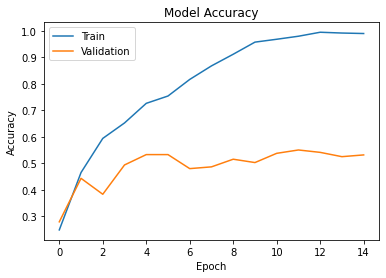

In [ ]:
# View the model performance in a chart
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Observations
Training accuracy improves to near 100% after 14 epochs, but validation accuracy levels off a little over 50% after 4 epochs and doesn't improve much thereafter. This is not a great model right now and could definitely use some parameter tuning. Adding additional convolutional layers and/or dense layers might help performance. 

## Making Predictions

In [ ]:
# Making predictions on the test data
y_pred_test = model.predict(X_test)

# Converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

              precision    recall  f1-score   support

           0       0.25      0.05      0.08        80
           1       0.47      0.50      0.48       109
           2       0.54      0.42      0.47        91
           3       0.64      0.58      0.61       187
           4       0.16      0.14      0.15        71
           5       0.64      0.35      0.46       147
           6       0.52      0.76      0.62       186
           7       0.58      0.28      0.38        64
           8       0.48      0.61      0.53       160
           9       0.33      0.67      0.44        64
          10       0.79      0.74      0.76       144
          11       0.40      0.45      0.42       122

    accuracy                           0.51      1425
   macro avg       0.48      0.46      0.45      1425
weighted avg       0.52      0.51      0.50      1425



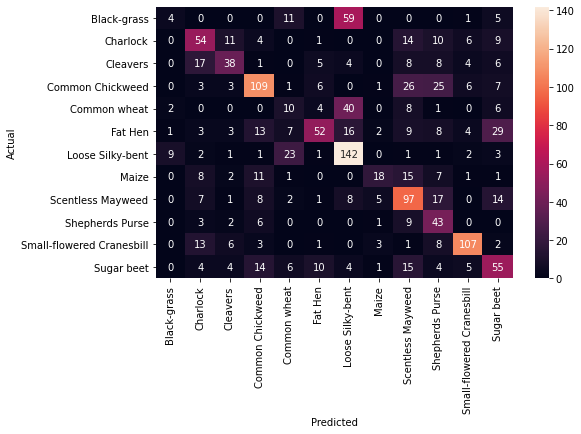

In [ ]:
#Printing the classification report
print(classification_report(y_test, y_pred_test_classes))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=plant_classes, yticklabels=plant_classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Observations
This model struggled in a number of areas. Precision, recall, and F1 scores are all around 0.50, which is very low. Additionally, the model often predicted...


*   Sugar beet when it was actually Fat Hen (29 times)
*   Common wheat when it was actually Loose Silky-bent (23 times)
*   Loose Silky-bent when it was actually Black-grass (59 times)

The model performed relatively well at correctly identifying Common Chickweed, Fat Hen, Maize, Scentless Mayweed, and Small-flowered Cranesbill.





# Step 6: Visualize Predictions
Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

Predicted plant: Loose Silky-bent
Actual plant: Common wheat
Probability: 0.9913497


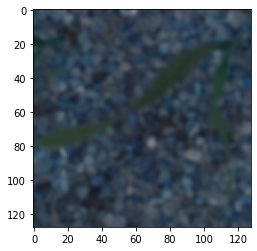

In [ ]:
# Visualize prediction for X_test[2]

i = 2
image = X_test[i]
pred = plant_classes[y_pred_test_classes[i]]
act = plant_classes[y_test[i][0]]
pred_proba = y_pred_test_max_probas[i]

plt.imshow(image)
print("Predicted plant:", pred)
print("Actual plant:", act)
print("Probability:", pred_proba)

Predicted plant: Loose Silky-bent
Actual plant: Loose Silky-bent
Probability: 0.9928762


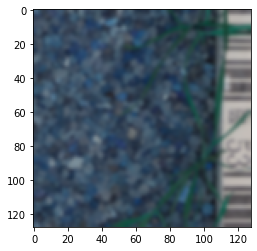

In [ ]:
# Visualize prediction for X_test[3]

i = 3
image = X_test[i]
pred = plant_classes[y_pred_test_classes[i]]
act = plant_classes[y_test[i][0]]
pred_proba = y_pred_test_max_probas[i]

plt.imshow(image)
print("Predicted plant:", pred)
print("Actual plant:", act)
print("Probability:", pred_proba)

Predicted plant: Loose Silky-bent
Actual plant: Fat Hen
Probability: 0.9645568


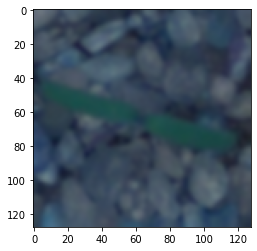

In [ ]:
# Visualize prediction for X_test[33]

i = 33
image = X_test[i]
pred = plant_classes[y_pred_test_classes[i]]
act = plant_classes[y_test[i][0]]
pred_proba = y_pred_test_max_probas[i]

plt.imshow(image)
print("Predicted plant:", pred)
print("Actual plant:", act)
print("Probability:", pred_proba)

Predicted plant: Loose Silky-bent
Actual plant: Common wheat
Probability: 0.9955603


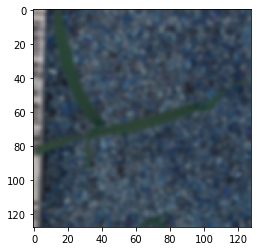

In [ ]:
# Visualize prediction for X_test[36]

i = 36
image = X_test[i]
pred = plant_classes[y_pred_test_classes[i]]
act = plant_classes[y_test[i][0]]
pred_proba = y_pred_test_max_probas[i]

plt.imshow(image)
print("Predicted plant:", pred)
print("Actual plant:", act)
print("Probability:", pred_proba)

Predicted plant: Scentless Mayweed
Actual plant: Scentless Mayweed
Probability: 0.9774804


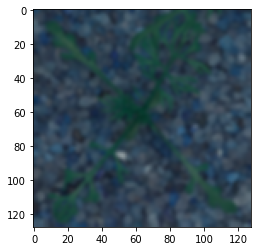

In [ ]:
# Visualize prediction for X_test[59]

i = 59
image = X_test[i]
pred = plant_classes[y_pred_test_classes[i]]
act = plant_classes[y_test[i][0]]
pred_proba = y_pred_test_max_probas[i]

plt.imshow(image)
print("Predicted plant:", pred)
print("Actual plant:", act)
print("Probability:", pred_proba)

#### Observations
Sometimes the predicted probability was quite high when the model got the prediction wrong (as in X_test[2], where it had a .99 probability and was incorrect). 

# Conclusion
In this project, I created a simple CNN model from scratch to function as a classifier capable of determining a plant's species from a photo. 


*   I imported a large set of image data and used python to visualize the images from the pixel-level data. 
*   I prepared the images using normalization and Gaussian blurring. 
*   I used one-hote encoding to encode the class labels
*   I split the data into training, test, and validation sets
*   I checked the shape of the data to make sure it was compatiable to create a Sequential model
*   I built a simple Sequential model using Tensflow's implementation of Keras. I included 2 convolutional layers, a flatten later, and 2 dense layers. 
*   I fit and evaluated the model performance
*   I visualized a few examples of the predictions the model made, including the predicted probability. 

My basic model worked but did not perform very well. It would likely benefit from hypertuning parameters and adding more convolution layers and dense layers.  